In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("billets.csv", sep=";")

In [2]:
df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
df.columns.tolist()

['is_genuine',
 'diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length']

In [5]:
colonne = ['diagonal','height_left','height_right','margin_low','margin_up','length']

In [6]:
display(df[colonne].describe().T)

count        mean       std     min      25%     50%     75%  \
diagonal      1500.0  171.958440  0.305195  171.04  171.750  171.96  172.17   
height_left   1500.0  104.029533  0.299462  103.14  103.820  104.04  104.23   
height_right  1500.0  103.920307  0.325627  102.82  103.710  103.92  104.15   
margin_low    1463.0    4.485967  0.663813    2.98    4.015    4.31    4.87   
margin_up     1500.0    3.151473  0.231813    2.27    2.990    3.14    3.31   
length        1500.0  112.678500  0.872730  109.49  112.030  112.96  113.34   

                 max  
diagonal      173.01  
height_left   104.88  
height_right  104.95  
margin_low      6.90  
margin_up       3.91  
length        114.44

In [7]:
df['is_fake'] = (~df['is_genuine'].astype(bool)).astype(int)  # 1=faux, 0=vrai
print("Répartition (0=vrai, 1=faux) :")
display(df['is_fake'].value_counts().to_frame('count').assign(pct=lambda s: (100*s['count']/s['count'].sum()).round(2)))

Répartition (0=vrai, 1=faux) :


count    pct
is_fake              
0         1000  66.67
1          500  33.33

In [8]:
na_counts = df[colonne].isna().sum().sort_values(ascending=False)

In [9]:
na_counts

margin_low      37
diagonal         0
height_left      0
height_right     0
margin_up        0
length           0
dtype: int64

In [10]:
print("Valeurs manquantes par colonne :")
display(na_counts.to_frame("nb_manquants").assign(pct=lambda s: (100*s['nb_manquants']/len(df)).round(2)))

Valeurs manquantes par colonne :


nb_manquants   pct
margin_low              37  2.47
diagonal                 0  0.00
height_left              0  0.00
height_right             0  0.00
margin_up                0  0.00
length                   0  0.00

In [11]:
colonne_na = [c for c in colonne if df[c].isna().any()]
if not colonne_na:
    print("✅")
else:
    cible = colonne_na[0]  
    print("On va tester la régression pour imputer la colonne :", cible)

On va tester la régression pour imputer la colonne : margin_low


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
if 'cible' in locals():
    predictors = [c for c in colonne if c != cible]
    df_complete = df.dropna(subset=[cible]).copy()
    df_complete = df_complete.dropna(subset=predictors)

    X = df_complete[predictors].values
    y = df_complete[cible].values

    print(f"Lignes utilisées pour la régression d'imputation de {cible} :", X.shape[0])
else:
    print("Pas de colonne à imputer sélectionnée.")

Lignes utilisées pour la régression d'imputation de margin_low : 1463


In [14]:
#1 Linéarité
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan
from scipy.stats import normaltest

X_ols = sm.add_constant(df_complete[predictors])
model = sm.OLS(df_complete[cible], X_ols).fit()

In [15]:
reset = linear_reset(model, power=2, use_f=True)
print(f"Ramsey RESET — F={reset.fvalue:.3f} / p-value={reset.pvalue:.4g}")

Ramsey RESET — F=1.123 / p-value=0.2895


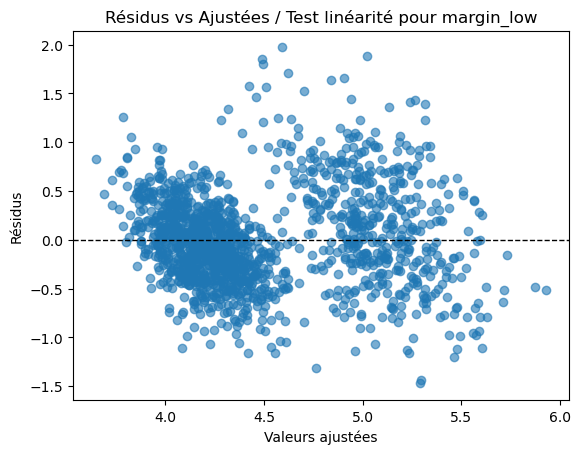

In [16]:
fitted = model.fittedvalues
resid = model.resid

plt.figure()
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Valeurs ajustées")
plt.ylabel("Résidus")
plt.title(f"Résidus vs Ajustées / Test linéarité pour {cible}")
plt.show()

In [17]:
#2 Test de normalité (D’Agostino/Pearson)
resid = model.resid
k2, p_norm = normaltest(resid, nan_policy='omit')
print(f"Normalité (D’Agostino) — stat={k2:.3f} / p-value={p_norm:.4g}")

Normalité (D’Agostino) — stat=73.627 / p-value=1.028e-16


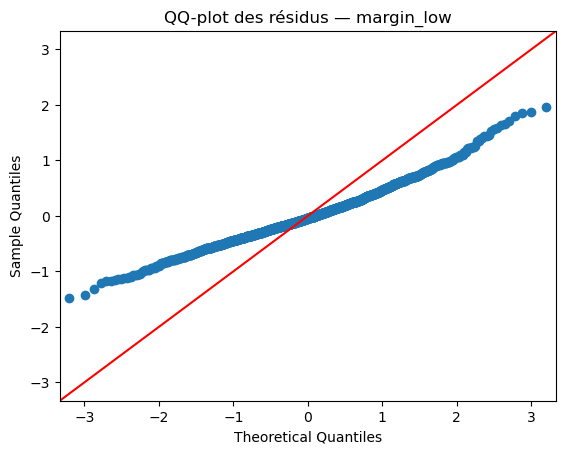

In [18]:
sm.qqplot(resid, line='45')
plt.title(f"QQ-plot des résidus — {cible}")
plt.show()

In [19]:
# Breusch–Pagan
resid = model.resid
lm_stat, lm_pval, f_stat, f_pval = het_breuschpagan(resid, model.model.exog)
print(f"Breusch–Pagan — LM p-value={lm_pval:.4g} / F p-value={f_pval:.4g}")

Breusch–Pagan — LM p-value=7.76e-16 / F p-value=2.923e-16


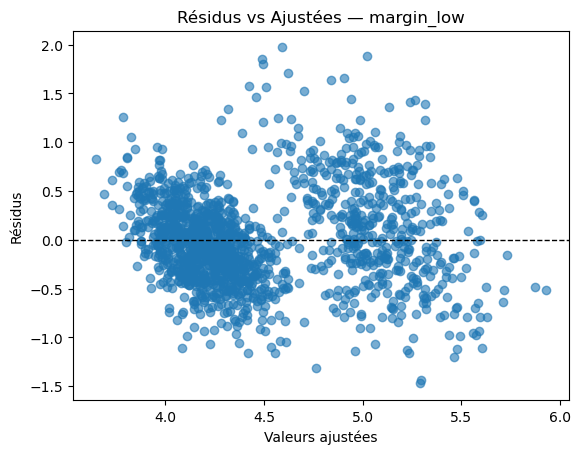

In [20]:
# hétéroscédasticité
fitted = model.fittedvalues
plt.figure()
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel("Valeurs ajustées")
plt.ylabel("Résidus")
plt.title(f"Résidus vs Ajustées — {cible}")
plt.show()

In [21]:
df_liniaire = df.copy(deep=True)

In [22]:
feature_cols = ['diagonal','height_left','height_right','margin_low','margin_up','length']
for c in feature_cols:
    df_liniaire[c] = pd.to_numeric(df_liniaire[c], errors='coerce')

In [23]:
na_counts = df_liniaire[feature_cols].isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("nb_manquants"))

nb_manquants
margin_low              37
diagonal                 0
height_left              0
height_right             0
margin_up                0
length                   0

In [24]:
cols_with_na = [c for c in feature_cols if df_liniaire[c].isna().any()]
if cols_with_na:
    target_feature = cols_with_na[0] 
    print("Colonne choisie pour l'exercice :", target_feature)
else:
    target_feature = None
    print("Aucune valeur manquante trouvée dans les features (rien à imputer).")

Colonne choisie pour l'exercice : margin_low


In [25]:
df_complete = df_liniaire.dropna(subset=[target_feature] + predictors).copy()
print(f"Lignes utilisées pour entraîner l'OLS : {len(df_complete)}")

Lignes utilisées pour entraîner l'OLS : 1463


In [26]:
X = sm.add_constant(df_complete[predictors])
y = df_complete[target_feature]
ols = sm.OLS(y, X).fit()
print(ols.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 12 Sep 2025   Prob (F-statistic):          2.60e-202
Time:                        13:10:20   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         


In [27]:
df_missing = df_liniaire[df_liniaire[target_feature].isna()].copy()
predictable_mask = df_missing[predictors].notna().all(axis=1)
n_predictable = int(predictable_mask.sum())
print(f"Lignes manquantes au total : {len(df_missing)} | prédictibles par OLS : {n_predictable}")

if n_predictable > 0:
        X_miss = sm.add_constant(df_missing.loc[predictable_mask, predictors])
        y_hat = ols.predict(X_miss)

Lignes manquantes au total : 37 | prédictibles par OLS : 37


In [28]:
# 4) Imputer dans df_liniaire
idx_to_fill = df_missing.loc[predictable_mask].index
df_liniaire.loc[idx_to_fill, target_feature] = y_hat.values

In [29]:
if target_feature is not None:
    print("NA restants après imputation sur df_liniaire :")
    print(df_liniaire[target_feature].isna().sum())

    # Comparaison de stats
    print("\nStatistiques de la colonne imputée sur df_liniaire :")
    display(df_liniaire[target_feature].describe(percentiles=[.05,.25,.5,.75,.95]).to_frame().T)

NA restants après imputation sur df_liniaire :
0

Statistiques de la colonne imputée sur df_liniaire :


count      mean       std   min    5%   25%   50%   75%     95%  \
margin_low  1500.0  4.483475  0.659632  2.98  3.66  4.02  4.31  4.87  5.7905   

            max  
margin_low  6.9

<h1 style="; font-size:42px; margin:0.4em 0">
 AMPUTATION VALEUR MARGIN LOW
</h1>

In [71]:
# 1) Colonnes concernées (les 6 mesures)
features = ["diagonal","height_left","height_right","margin_low","margin_up","length"]

# (sécurité) convertir en numérique
for c in features:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) Créer des indicateurs de manquants (0/1) AVANT imputation
missing_flags = df[features].isna().astype(int).add_suffix("_missing")

# 3) Imputation médiane
imp = SimpleImputer(strategy="median")
features_imputed = pd.DataFrame(
    imp.fit_transform(df[features]),
    columns=features,
    index=df.index
)

# 4) Reconstruire le DataFrame imputé + flags
df_impute = df.copy()
df_impute[features] = features_imputed
df_impute = pd.concat([df_impute, missing_flags], axis=1)

# 5) Petit contrôle
print("Manquants avant imputation :")
print(df[features].isna().sum())
print("\nManquants après imputation :")
print(df_impute[features].isna().sum())

Manquants avant imputation :
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Manquants après imputation :
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [80]:
df.count()

is_genuine      1500
diagonal        1500
height_left     1500
height_right    1500
margin_low      1463
margin_up       1500
length          1500
is_fake         1500
dtype: int64

<h1 style="color:#1976d2; font-size:42px; margin:0.4em 0">
  Algorithme - K-means
</h1>

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import (confusion_matrix, accuracy_score,precision_recall_fscore_support, classification_report)

In [32]:
df["is_fake"] = (~df["is_genuine"].astype(bool)).astype(int)
features = ["diagonal","height_left","height_right","margin_low","margin_up","length"]
for c in features:
    df[c] = pd.to_numeric(df[c], errors="coerce")
X = df[features].values
y = df["is_fake"].values

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("train:", X_train.shape, "test:", X_test.shape)

train: (1200, 6) test: (300, 6)


In [34]:
kmeans_pipe = Pipeline([
    ("imp",    SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=2, n_init=20, random_state=42))])
kmeans_pipe.fit(X_train)
print("OK: K-means entraîné.")

OK: K-means entraîné.


C:\Users\David\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\David\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\David\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\David\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\David\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

In [35]:
# Clusters train
train_clusters = kmeans_pipe.predict(X_train)

In [36]:
# Clusters train
train_clusters = kmeans_pipe.predict(X_train)

# Majorité
mapping = {}
for c in np.unique(train_clusters):
    labels_c = y_train[train_clusters == c]
    mapping[c] = int(np.bincount(labels_c).argmax())

print("Mapping cluster -> label :", mapping)

Mapping cluster -> label : {0: 1, 1: 0}


<h1 style="color:#FF0000; font-size:30px; margin:0.4em 0">
  Résultat K-means :
</h1>

In [38]:
# Clusters test
test_clusters = kmeans_pipe.predict(X_test)
y_pred = np.array([mapping[c] for c in test_clusters])

# Métrique
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

print("=== K-means (k=2) — Évaluation TEST ===")
print("Accuracy :", round(acc, 4))
print("Precision  :", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1     :", round(f1, 4))
print("Matrice de confusion :\n", cm)
print("\nClassification report :\n", classification_report(y_test, y_pred, target_names=["vrai(0)","faux(1)"]))

=== K-means (k=2) — Évaluation TEST ===
Accuracy : 0.9867
Precision  : 0.9898
Recall   : 0.97
F1     : 0.9798
Matrice de confusion :
 [[199   1]
 [  3  97]]

Classification report :
               precision    recall  f1-score   support

     vrai(0)       0.99      0.99      0.99       200
     faux(1)       0.99      0.97      0.98       100

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



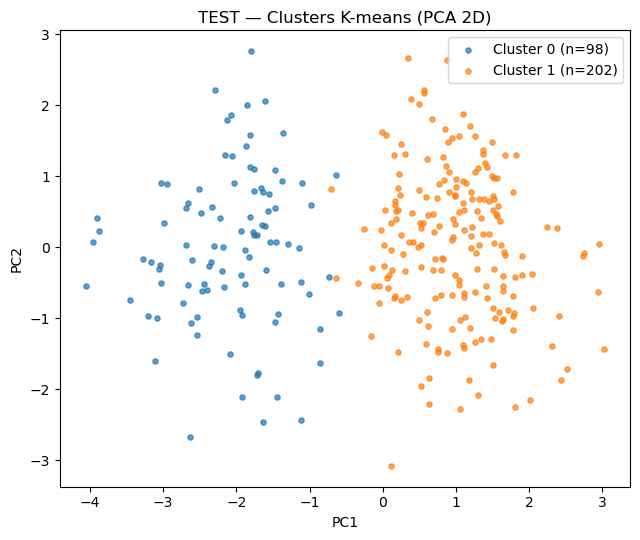

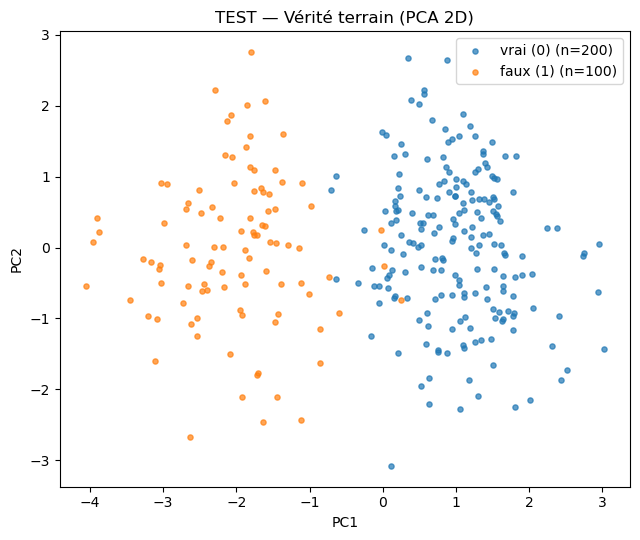

In [39]:
from sklearn.decomposition import PCA
imp = kmeans_pipe.named_steps["imp"]
scaler = kmeans_pipe.named_steps["scaler"]
X_train_scaled = scaler.transform(imp.transform(X_train))
X_test_scaled  = scaler.transform(imp.transform(X_test))

pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

plt.figure(figsize=(6.5,5.5))
for c in np.unique(test_clusters):
    m = (test_clusters == c)
    plt.scatter(X_test_pca[m,0], X_test_pca[m,1], s=14, alpha=0.7, label=f"Cluster {c} (n={m.sum()})")
plt.title("TEST — Clusters K-means (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5,5.5))
for cls, name in [(0,"vrai (0)"), (1,"faux (1)")]:
    m = (y_test == cls)
    plt.scatter(X_test_pca[m,0], X_test_pca[m,1], s=14, alpha=0.7, label=f"{name} (n={m.sum()})")
plt.title("TEST — Vérité terrain (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()

<h1 style="color:#1976d2; font-size:42px; margin:0.4em 0">
  Algorithme - KNN
</h1>

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("train:", X_train.shape, "test:", X_test.shape)

train: (1200, 6) test: (300, 6)


In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report)
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_recall_fscore_support,classification_report, roc_curve, roc_auc_score)

knn = Pipeline([
    ("imp",    SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf",    KNeighborsClassifier(n_neighbors=5, weights="distance", p=2)) 
])

knn.fit(X_train, y_train)
print("OK: KNN entraîné.")

OK: KNN entraîné.


In [43]:
# Prédiction
y_pred = knn.predict(X_test)

In [44]:
# Proba
try:
    y_proba = knn.predict_proba(X_test)[:, 1]
except Exception:
    y_proba = None

<h1 style="color:#FF0000; font-size:30px; margin:0.4em 0">
  Résultat KNN :
</h1>

In [46]:
# Métrique
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

print("=== KNN — Évaluation TEST ===")
print("Accuracy :", round(acc, 4))
print("Precision  :", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1     :", round(f1, 4))
print("Matrice de confusion :\n", cm)
print("\nClassification report :\n", classification_report(y_test, y_pred, target_names=["vrai(0)","faux(1)"]))

=== KNN — Évaluation TEST ===
Accuracy : 0.99
Precision  : 1.0
Recall   : 0.97
F1     : 0.9848
Matrice de confusion :
 [[200   0]
 [  3  97]]

Classification report :
               precision    recall  f1-score   support

     vrai(0)       0.99      1.00      0.99       200
     faux(1)       1.00      0.97      0.98       100

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



<h1 style="color:#1976d2; font-size:42px; margin:0.4em 0">
  Algorithme - Régression logistique
</h1>

In [48]:
from sklearn.linear_model import LogisticRegression
log_reg = Pipeline([
    ("imp",    SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf",    LogisticRegression(
        max_iter=2000, solver="liblinear", class_weight="balanced", penalty="l2", C=1.0
    ))
])

log_reg.fit(X_train, y_train)
print("OK: Régression logistique entraînée (baseline).")

OK: Régression logistique entraînée (baseline).


<h1 style="color:#FF0000; font-size:30px; margin:0.4em 0">
  Résultat Régression Logistique :
</h1>

In [50]:
# Prédiction
y_pred  = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1] 

# Métrique
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

print("=== Régression logistique — Évaluation TEST ===")
print("Accuracy :", round(acc, 4))
print("Precision :", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1     :", round(f1, 4))
print("Matrice de confusion :\n", cm)
print("\nClassification report :\n", classification_report(y_test, y_pred, target_names=["vrai(0)","faux(1)"]))

=== Régression logistique — Évaluation TEST ===
Accuracy : 0.99
Precision : 1.0
Recall   : 0.97
F1     : 0.9848
Matrice de confusion :
 [[200   0]
 [  3  97]]

Classification report :
               precision    recall  f1-score   support

     vrai(0)       0.99      1.00      0.99       200
     faux(1)       1.00      0.97      0.98       100

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



In [51]:
auc = roc_auc_score(y_test, y_proba)
print("AUC ROC :", round(auc, 4))

AUC ROC : 0.999


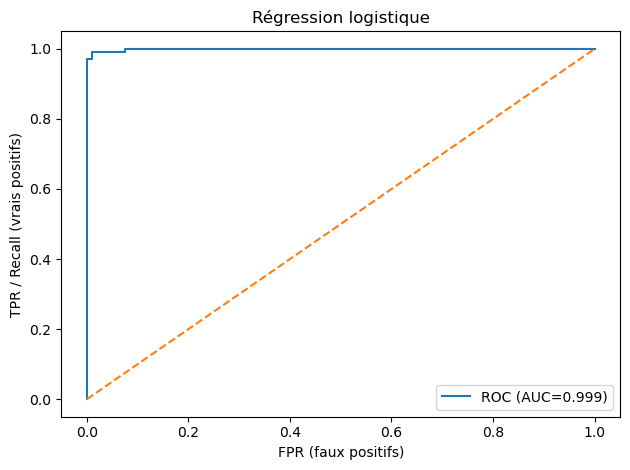

In [52]:
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR (faux positifs)"); plt.ylabel("TPR / Recall (vrais positifs)")
plt.title("Régression logistique")
plt.legend(); plt.tight_layout(); plt.show()

<h1 style="color:#1976d2; font-size:42px; margin:0.4em 0">
  Algorithme - Random Forest
</h1>

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_recall_fscore_support,classification_report, roc_auc_score, roc_curve)

In [55]:
rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        random_state=42,
        class_weight="balanced", 
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
print("OK: Random Forest entraînée (baseline).")

OK: Random Forest entraînée (baseline).


<h1 style="color:#FF0000; font-size:30px; margin:0.4em 0">
  Résultat Random Forest :
</h1>

In [57]:
# Prédiction
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Métrique
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("=== Random Forest — Évaluation TEST ===")
print("Accuracy :", round(acc, 4))
print("Precision :", round(prec, 4))
print("Recall   :", round(rec, 4))
print("F1    :", round(f1, 4))
print("AUC ROC   :", round(auc, 4))
print("Matrice de confusion :\n", cm)
print("\nClassification report :\n", classification_report(y_test, y_pred, target_names=["vrai(0)","faux(1)"]))

=== Random Forest — Évaluation TEST ===
Accuracy : 0.9867
Precision : 0.9898
Recall   : 0.97
F1    : 0.9798
AUC ROC   : 0.9992
Matrice de confusion :
 [[199   1]
 [  3  97]]

Classification report :
               precision    recall  f1-score   support

     vrai(0)       0.99      0.99      0.99       200
     faux(1)       0.99      0.97      0.98       100

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



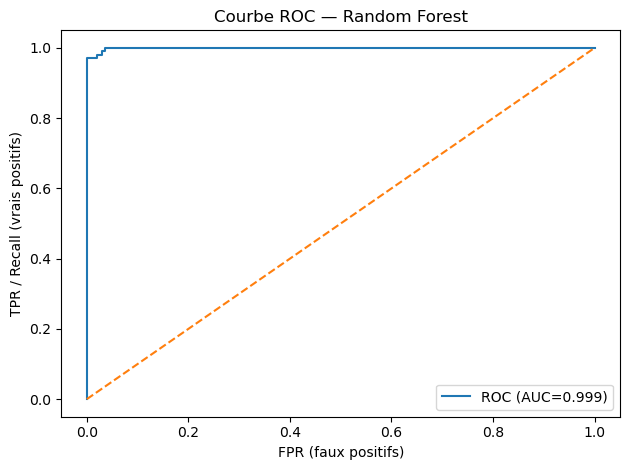

In [58]:
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR (faux positifs)"); plt.ylabel("TPR / Recall (vrais positifs)")
plt.title("Courbe ROC — Random Forest"); plt.legend(); plt.tight_layout(); plt.show()

In [59]:
# 1) Régression logistique
log_reg = Pipeline([
    ("imp",    SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf",    LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced"))
])

# 2) KNN
knn = Pipeline([
    ("imp",    SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf",    KNeighborsClassifier(n_neighbors=5, weights="distance", p=2))
])

# 3) Random Forest
rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2,
        random_state=42, class_weight="balanced", n_jobs=-1
    ))
])

# 4) K-means
kmeans_pipe = Pipeline([
    ("imp",    SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=2, n_init=20, random_state=42))
])

models = {
    "LogisticRegression": log_reg,
    "KNN": knn,
    "RandomForest": rf,
    "KMeans": kmeans_pipe
}

In [60]:
def eval_supervised(estimator, X_tr, y_tr, X_te, y_te, name):
    """Évalue un modèle supervisé standard (RL, KNN, RF)."""
    estimator.fit(X_tr, y_tr)
    y_pred = estimator.predict(X_te)
    # proba (AUC) si dispo
    try:
        y_proba = estimator.predict_proba(X_te)[:, 1]
        auc = roc_auc_score(y_te, y_proba)
    except Exception:
        auc = np.nan

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])  # [[TN,FP],[FN,TP]]
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)

    return {
        "Modèle": name,
        "Accuracy": acc,
        "Precision (faux=1)": prec,
        "Recall (faux=1)": rec,
        "F1 (faux=1)": f1,
        "AUC": auc,
        "Matrice de confusion": cm.tolist()
    }, estimator

def eval_kmeans(pipe, X_tr, y_tr, X_te, y_te):
    """Fit KMeans sur train, mapping cluster->label (majorité), puis évalue sur test."""
    pipe.fit(X_tr)  # non supervisé
    train_clusters = pipe.predict(X_tr)
    mapping = {}
    for c in np.unique(train_clusters):
        lab = y_tr[train_clusters == c]
        mapping[c] = int(np.bincount(lab).argmax())

    test_clusters = pipe.predict(X_te)
    y_pred = np.array([mapping[c] for c in test_clusters])

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    acc = accuracy_score(y_te, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)

    return {
        "Modèle": "KMeans (centroïdes)",
        "Accuracy": acc,
        "Precision (faux=1)": prec,
        "Recall (faux=1)": rec,
        "F1 (faux=1)": f1,
        "AUC": np.nan,
        "Matrice de confusion": cm.tolist()
    }, pipe
results = []
fitted = {}

for name, est in models.items():
    if name == "KMeans":
        res, fitted_est = eval_kmeans(est, X_train, y_train, X_test, y_test)
    else:
        res, fitted_est = eval_supervised(est, X_train, y_train, X_test, y_test, name)
    results.append(res)
    fitted[name] = fitted_est

results_df = pd.DataFrame(results).sort_values(
    by=["Recall (faux=1)", "F1 (faux=1)", "Accuracy"], ascending=[False, False, False]
).reset_index(drop=True)

results_df

C:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Modèle  Accuracy  Precision (faux=1)  Recall (faux=1)  \
0   LogisticRegression  0.990000            1.000000             0.97   
1                  KNN  0.990000            1.000000             0.97   
2         RandomForest  0.986667            0.989796             0.97   
3  KMeans (centroïdes)  0.986667            0.989796             0.97   

   F1 (faux=1)       AUC Matrice de confusion  
0     0.984772  0.999050  [[200, 0], [3, 97]]  
1     0.984772  0.984325  [[200, 0], [3, 97]]  
2     0.979798  0.999150  [[199, 1], [3, 97]]  
3     0.979798       NaN  [[199, 1], [3, 97]]

In [61]:
best_row = results_df.iloc[0]
print("=== Meilleur modèle selon le critère (Recall faux -> F1 -> Accuracy) ===")
print(f"Modèle : {best_row['Modèle']}")
print(f"Recall (faux=1) : {best_row['Recall (faux=1)']:.3f}")
print(f"F1 (faux=1)     : {best_row['F1 (faux=1)']:.3f}")
print(f"Accuracy        : {best_row['Accuracy']:.3f}")
if not np.isnan(best_row["AUC"]):
    print(f"AUC             : {best_row['AUC']:.3f}")
print("\n=== Matrices de confusion (TEST) ===")
for _, row in results_df.iterrows():
    print(f"\n{row['Modèle']}")
    cm = np.array(row["Matrice de confusion"])
    # format: [[TN, FP],[FN, TP]]
    print(pd.DataFrame(cm, index=["Vérité: vrai(0)", "Vérité: faux(1)"], columns=["Prédit: vrai(0)", "Prédit: faux(1)"]))

=== Meilleur modèle selon le critère (Recall faux -> F1 -> Accuracy) ===
Modèle : LogisticRegression
Recall (faux=1) : 0.970
F1 (faux=1)     : 0.985
Accuracy        : 0.990
AUC             : 0.999

=== Matrices de confusion (TEST) ===

LogisticRegression
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)              200                0
Vérité: faux(1)                3               97

KNN
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)              200                0
Vérité: faux(1)                3               97

RandomForest
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)              199                1
Vérité: faux(1)                3               97

KMeans (centroïdes)
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)              199                1
Vérité: faux(1)                3               97


<h1 style="color:#1976d2; font-size:42px; margin:0.4em 0">
  Validation par ré-échantillonnage "80 / 20" 
</h1>

In [63]:

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import numpy as np
import pandas as pd
models = {
    "LogisticRegression": log_reg,
    "KNN": knn,
    "RandomForest": rf,
    "KMeans": kmeans_pipe,}

N_SPLITS = 10      
TRAIN_SIZE = 0.80  
RANDOM_STATE = None

sss = StratifiedShuffleSplit(n_splits=N_SPLITS, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [64]:
# Accumulateurs
scores = {name: {"acc": [], "prec1": [], "rec1": [], "f1_1": [], "auc": []} for name in models}
cms_sum = {name: np.zeros((2,2), dtype=int) for name in models}

for split_id, (tr_idx, te_idx) in enumerate(sss.split(X, y), start=1):
    X_tr, X_te = X[tr_idx], X[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

    for name, est in models.items():
        est.fit(X_tr, y_tr) if name != "KMeans" else est.fit(X_tr)

        # Prédiction
        if name == "KMeans":
            tr_clusters = est.predict(X_tr)
            mapping = {c: int(np.bincount(y_tr[tr_clusters == c]).argmax()) for c in np.unique(tr_clusters)}
            te_clusters = est.predict(X_te)
            y_pred = np.array([mapping[c] for c in te_clusters])
            auc = np.nan
        else:
            y_pred = est.predict(X_te)
            if hasattr(est, "predict_proba"):
                y_proba = est.predict_proba(X_te)[:, 1]
                auc = roc_auc_score(y_te, y_proba)
            else:
                auc = np.nan

        # Métriques
        acc  = accuracy_score(y_te, y_pred)
        prec = precision_score(y_te, y_pred, pos_label=1, zero_division=0)
        rec  = recall_score(y_te, y_pred, pos_label=1, zero_division=0)
        f1   = f1_score(y_te, y_pred, pos_label=1, zero_division=0)
        cm   = confusion_matrix(y_te, y_pred, labels=[0,1])

        scores[name]["acc"].append(acc)
        scores[name]["prec1"].append(prec)
        scores[name]["rec1"].append(rec)
        scores[name]["f1_1"].append(f1)
        scores[name]["auc"].append(auc)
        cms_sum[name] += cm

C:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [65]:
# Tableau récap (moyenne ± écart-type)
def mean_std(a):
    a = np.array(a, dtype=float)
    return a.mean(), a.std()

rows = []
for name, d in scores.items():
    acc_m, acc_s = mean_std(d["acc"])
    p_m, p_s     = mean_std(d["prec1"])
    r_m, r_s     = mean_std(d["rec1"])
    f_m, f_s     = mean_std(d["f1_1"])
    auc_vals = np.array(d["auc"], dtype=float)
    if np.isnan(auc_vals).all():
        auc_m, auc_s = (np.nan, np.nan)
    else:
        auc_m, auc_s = mean_std(auc_vals[~np.isnan(auc_vals)])
    rows.append({
        "Modèle": name,
        "Recall(faux)_mean": r_m, "Recall(faux)_std": r_s,
        "F1(faux)_mean": f_m,     "F1(faux)_std": f_s,
        "Accuracy_mean": acc_m,   "Accuracy_std": acc_s,
        "AUC_mean": auc_m,        "AUC_std": auc_s
    })

cv_table = pd.DataFrame(rows).sort_values(
    by=["Recall(faux)_mean","F1(faux)_mean","Accuracy_mean"],
    ascending=[False, False, False]
).reset_index(drop=True)

In [66]:
# Affichage formaté
def fmt(m, s):
    if np.isnan(m): return "n/a"
    return f"{m:.4f} ± {s:.4f}"

show = cv_table.copy()
show["Recall(faux) (m±sd)"] = [fmt(m, s) for m,s in zip(show["Recall(faux)_mean"], show["Recall(faux)_std"])]
show["F1(faux) (m±sd)"]     = [fmt(m, s) for m,s in zip(show["F1(faux)_mean"], show["F1(faux)_std"])]
show["Accuracy (m±sd)"]     = [fmt(m, s) for m,s in zip(show["Accuracy_mean"], show["Accuracy_std"])]
show["AUC (m±sd)"]          = [fmt(m, s) for m,s in zip(show["AUC_mean"], show["AUC_std"])]

display(show[["Modèle","Recall(faux) (m±sd)","F1(faux) (m±sd)","Accuracy (m±sd)","AUC (m±sd)"]])

print("\n=== Classement (par Recall faux -> F1 faux -> Accuracy) ===")
for i, row in cv_table.iterrows():
    print(f"{i+1}. {row['Modèle']} | Recall={row['Recall(faux)_mean']:.4f} | F1={row['F1(faux)_mean']:.4f} | Acc={row['Accuracy_mean']:.4f}")

print("\n=== Matrices de confusion cumulées (somme sur les", N_SPLITS, "splits) ===")
for name, cm in cms_sum.items():
    print(f"\n{name}")
    df_cm = pd.DataFrame(cm, index=["Vérité: vrai(0)","Vérité: faux(1)"], columns=["Prédit: vrai(0)","Prédit: faux(1)"])
    print(df_cm)

Modèle Recall(faux) (m±sd)  F1(faux) (m±sd)  Accuracy (m±sd)  \
0  LogisticRegression     0.9780 ± 0.0117  0.9824 ± 0.0079  0.9883 ± 0.0052   
1        RandomForest     0.9680 ± 0.0133  0.9807 ± 0.0079  0.9873 ± 0.0051   
2                 KNN     0.9680 ± 0.0160  0.9807 ± 0.0099  0.9873 ± 0.0065   
3              KMeans     0.9650 ± 0.0150  0.9718 ± 0.0130  0.9813 ± 0.0086   

        AUC (m±sd)  
0  0.9987 ± 0.0016  
1  0.9994 ± 0.0005  
2  0.9911 ± 0.0039  
3              n/a


=== Classement (par Recall faux -> F1 faux -> Accuracy) ===
1. LogisticRegression | Recall=0.9780 | F1=0.9824 | Acc=0.9883
2. RandomForest | Recall=0.9680 | F1=0.9807 | Acc=0.9873
3. KNN | Recall=0.9680 | F1=0.9807 | Acc=0.9873
4. KMeans | Recall=0.9650 | F1=0.9718 | Acc=0.9813

=== Matrices de confusion cumulées (somme sur les 10 splits) ===

LogisticRegression
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)             1987               13
Vérité: faux(1)               22              978

KNN
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)             1994                6
Vérité: faux(1)               32              968

RandomForest
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)             1994                6
Vérité: faux(1)               32              968

KMeans
                 Prédit: vrai(0)  Prédit: faux(1)
Vérité: vrai(0)             1979               21
Vérité: faux(1)               35              965


<h1 style="color:#1976d2; font-size:42px; margin:0.4em 0">
  Pour DF Test
</h1>

In [68]:
import joblib
from pathlib import Path
FEATURES = ["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]

In [69]:
# (1) Rechargement d'un modèle déjà entraîné si dispo ; sinon entraînement sur billets.csv
import pandas as pd, numpy as np, joblib
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

MODEL_PATH = Path("model_logreg_final.joblib")
if MODEL_PATH.exists():
    payload = joblib.load(MODEL_PATH)
    log_reg_final = payload["model"]
    FEATURES = payload.get("features", FEATURES)
    print("✅ Modèle rechargé depuis", MODEL_PATH)
else:
    train_df = pd.read_csv("billets.csv", sep=";")
    train_df["is_fake"] = (~train_df["is_genuine"].astype(bool)).astype(int)
    for c in FEATURES:
        train_df[c] = pd.to_numeric(train_df[c], errors="coerce")

    X_train_all = train_df[FEATURES].values
    y_train_all = train_df["is_fake"].values

    log_reg_final = Pipeline([
        ("imp",    SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf",    LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced"))
    ]).fit(X_train_all, y_train_all)

    joblib.dump({"model": log_reg_final, "features": FEATURES}, MODEL_PATH)
    print("✅ Modèle entraîné et sauvegardé ->", MODEL_PATH)

✅ Modèle rechargé depuis model_logreg_final.joblib


In [70]:
# 1) Import
prod_df = pd.read_csv("billets_production.csv", sep=None, engine="python")
prod_df.columns = [c.strip().lower().replace(" ", "_") for c in prod_df.columns]

#2 Vérifier la présence des 6 mesures attendues
missing = [c for c in FEATURES if c not in prod_df.columns]
if missing:
    raise ValueError(f"Colonnes manquantes : {missing}\nColonnes attendues : {FEATURES}")

for c in FEATURES:
    prod_df[c] = pd.to_numeric(prod_df[c], errors="coerce")

#3 Prédictions
X_prod = prod_df[FEATURES].values
proba_fake = log_reg_final.predict_proba(X_prod)[:, 1]
is_fake_pred = (proba_fake >= THRESHOLD).astype(int)
label_pred = np.where(is_fake_pred == 1, "faux", "vrai")

#4 tableau
id_col = next((c for c in ["id","id_billet","index","identifiant"] if c in prod_df.columns), None)
mini = pd.DataFrame({
    (id_col or "billet_id"): prod_df[id_col] if id_col else prod_df.index,
    "proba_faux": np.round(proba_fake, 4),
    "prediction": label_pred})

print("Résumé des prédictions :")
print(mini["prediction"].value_counts())
mini.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'billets_production.csv'